# Financial Analytics
---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import statsmodels.api as sm
import warnings

from scipy import stats
from scipy.stats import probplot
    
%matplotlib inline
warnings.filterwarnings("ignore")

Get the data from quandl and store it in a dataframe...

In [3]:
QUANDL_API_KEY = 'Uy8cAhTFD43Ar_u4sRrr' 
quandl.ApiConfig.api_key = QUANDL_API_KEY
df = quandl.get('EURONEXT/ABN')
df.head(5)

,Open,High,Low,Last,Volume,Turnover
Date,,,,,,
2015-11-20,18.18,18.43,18.000,18.35,38392898.0,7.003281e+08
2015-11-23,18.45,18.70,18.215,18.61,3352514.0,6.186446e+07
2015-11-24,18.70,18.80,18.370,18.80,4871901.0,8.994087e+07
2015-11-25,18.85,19.50,18.770,19.45,4802607.0,9.153862e+07
2015-11-26,19.48,19.67,19.410,19.43,1648481.0,3.220713e+07


Plot the data using pandas inbuilt method...

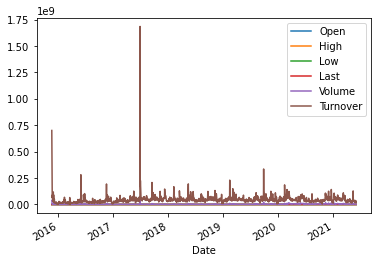

In [4]:
df.plot();

Plot the price and volume chart...

...top chart is price, the bottom volume.

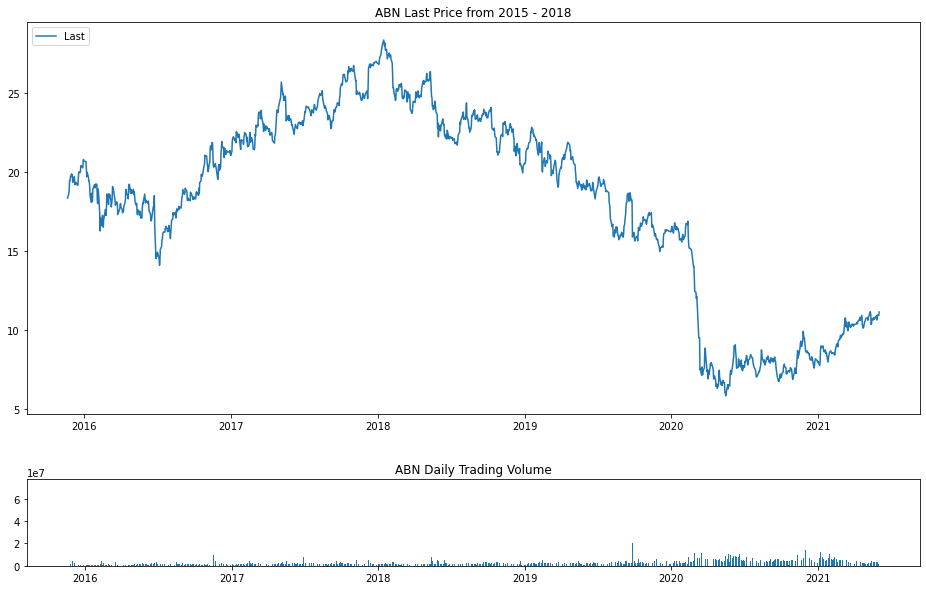

In [5]:
prices  = df['Last']
volumes = df['Volume']

top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
top.plot(prices.index, prices, label='Last')
plt.title('ABN Last Price from 2015 - 2018')
plt.legend(loc=2)

bottom = plt.subplot2grid((4, 4), (3,0), rowspan=1, colspan=4)
bottom.bar(volumes.index, volumes)
plt.title('ABN Daily Trading Volume')

plt.gcf().set_size_inches(16, 10)
plt.subplots_adjust(hspace=0.75)

- **subplot2grid()** with the first parameter, (4,4), divides the entire graph into a 4 x 4 grid. 
- The second parameter (0,0) specifies that the plot will be anchored top-left corner of the graph. 
- rowspan=3, indicates the plot will occupy 3 of the 4 available rows on the grid
- colspan=4, indicates that the plot will occupy all 4 columns of the grid (i.e. whole width). 
- The command returns a matplotlib axis object

### Plotting a candlestick chart
---
 
A candlestick represents a tick at each particular point of time with: the open, the high, the low, and the close.

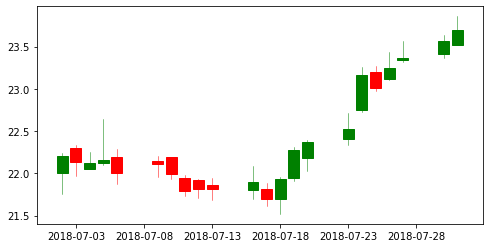

In [6]:
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = QUANDL_API_KEY

df_subset = quandl.get('EURONEXT/ABN', start_date='2018-07-01', end_date='2018-07-31')
df_subset['Date'] = df_subset.index.map(mdates.date2num)
df_ohlc = df_subset[['Date','Open', 'High', 'Low', 'Last']]

figure, ax = plt.subplots(figsize = (8,4))
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)

candlestick_ohlc(ax, df_ohlc.values, width=0.8, colorup='green', colordown='red');

#### Plotting Returns

A simple method for calculating returns in pandas is pct_change 

The percentage change from the previous row is computed for every row in the DataFrame.

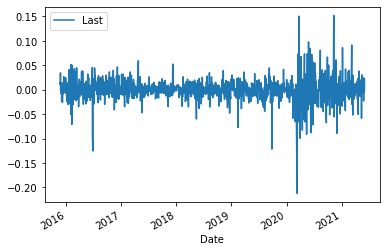

In [7]:
df = quandl.get('EURONEXT/ABN.4')
daily_changes = df.pct_change(periods=1)
daily_changes.plot();

and cumulative returns...

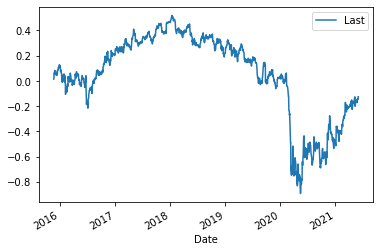

In [8]:
df_cumsum = daily_changes.cumsum()
df_cumsum.plot();

and a histogram...

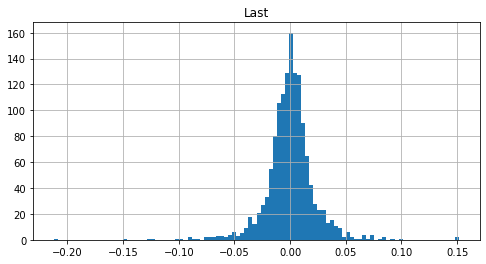

In [9]:
daily_changes.hist(bins=100, figsize=(8, 4));

In [10]:
daily_changes.describe()

,Last
count,1408.000000
mean,-0.000089
std,0.022877
min,-0.212453
25%,-0.009574
50%,0.000283
75%,0.009749
max,0.152042


#### Plotting volatility

One way of analyzing the distribution of returns is measuring its standard deviation. 

Standard deviation is a measure of dispersion around the mean. 

High standard deviation value indicates a high historical volatility of stock price movement.

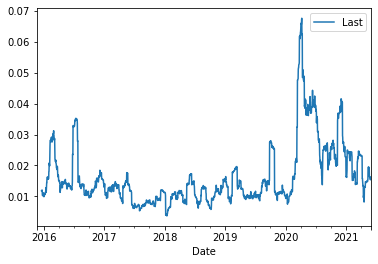

In [11]:
df_filled  = df.asfreq('D', method='ffill')
df_returns = df_filled.pct_change()
df_std = df_returns.rolling(window=30, min_periods=30).std()
df_std.plot();

#### A quantile-quantile plot

The quantiles of two distributions are plotted against each other. 

If the distributions are linearly related, the points in the Q-Q plot will lie along a line.  

Q-Q plots help us to visualize negative skews, as well as excess kurtosis.

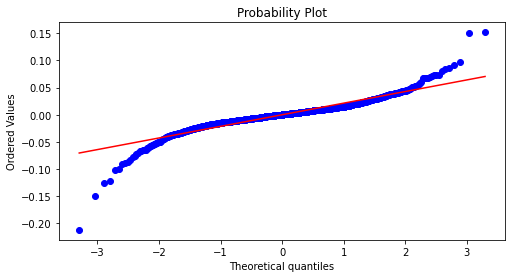

In [12]:
daily_changes = df.pct_change(periods=1).dropna()

figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
stats.probplot(daily_changes['Last'], dist='norm', plot=ax)
plt.show();

You can download multiple time series data at the same time...

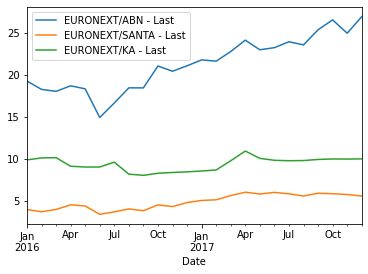

In [13]:
df = quandl.get(['EURONEXT/ABN.4', 'EURONEXT/SANTA.4', 'EURONEXT/KA.4'], 
                 collapse='monthly', start_date='2016-01-01', end_date='2017-12-31')
df.plot();

In [14]:
df.pct_change().corr()

,EURONEXT/ABN - Last,EURONEXT/SANTA - Last,EURONEXT/KA - Last
EURONEXT/ABN - Last,1.000000,0.809824,0.096238
EURONEXT/SANTA - Last,0.809824,1.000000,0.058095
EURONEXT/KA - Last,0.096238,0.058095,1.000000


#### Simple moving averages

A common technical indicator for time series data analysis is moving averages. 

The mean() method can be used to compute the mean of values for a given window in the rolling() command. 

These two moving averages can be used together to generate crossover signals.

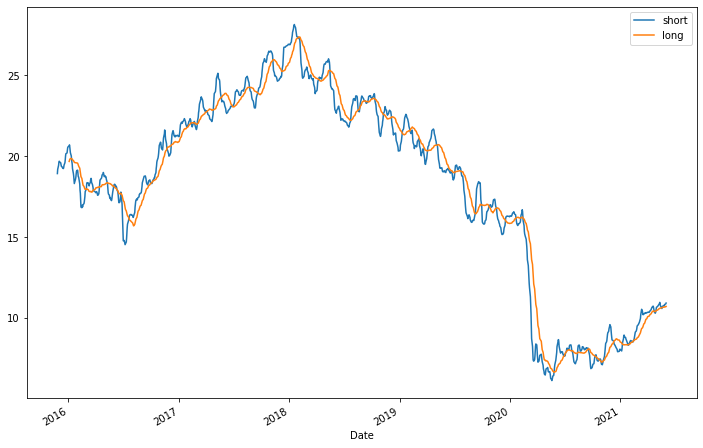

In [15]:
df = quandl.get('EURONEXT/ABN.4')

df_filled = df.asfreq('D', method='ffill')
df_last   = df['Last']

series_short = df_last.rolling(window=5,  min_periods=5).mean()
series_long  = df_last.rolling(window=30, min_periods=30).mean()

df_sma = pd.DataFrame(columns=['short', 'long'])
df_sma['short'] = series_short
df_sma['long']  = series_long
df_sma.plot(figsize=(12, 8));

#### Exponential moving averages

With EMA, the most recent prices are assigned a higher weight than older prices. 

This weight is assigned on an exponential basis.

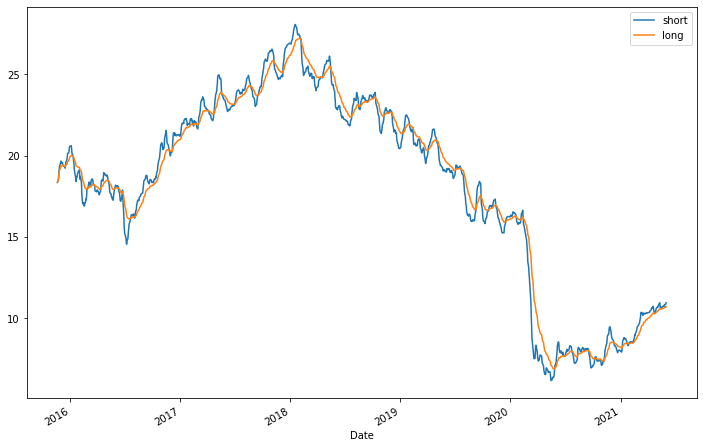

In [16]:
series_short = df_last.ewm(span=5).mean()
series_long  = df_last.ewm(span=30).mean()

df_sma = pd.DataFrame(columns=['short', 'long'])
df_sma['short'] = series_short
df_sma['long']  = series_long
df_sma.plot(figsize=(12, 8));

### Capital Asset Pricing Model
---

In the CAPM, the relationship between risk and rates of return in a security is described as follows:

$$ \large{ R_i = R_f + \beta_i (E[R_{mkt}] - R_f)} $$

For a security, i, its returns are defined as Ri and its beta as βi. 

The CAPM defines the return of the security as the sum of the risk-free rate, Rf, and the multiplication of its beta with the risk premium. 

The risk premium can be thought of as the market portfolio's excess returns exclusive of the risk-free rate.



In [17]:
stock_returns = [0.065, 0.0265, -0.0593, -0.001, 0.0346]
mkt_returns   = [0.055, -0.090, -0.0410, 0.0450, 0.0220]

beta, alpha, r_value, p_value, std_err = stats.linregress(stock_returns, mkt_returns)
print(beta, alpha)

0.5077431878770808 -0.008481900352462384


In [25]:
rf = 0.05
exp_mkt = 0.135
exp_r = rf + (beta * (exp_mkt - rf))
exp_r

0.09315817096955187

### Arbitrage Pricing Theory model
---

The APT model assumes that the security returns are generated according to multiple factor models, which consist of a linear combination of several systematic risk factors. Such factors could be the inflation rate, GDP growth rate, real interest rates, or dividends.

The equilibrium asset pricing equation according to the APT model is as follows:

$$ \large{E[R_i] = \alpha_i + \beta_{i,1}F_1 + \beta_{i,2}F_ + ...\beta_{i,j}F_j }$$

Here, $E[R_i]$ is the expected rate of return on the i security, $\alpha_i$ is the expected return on the i stock if all factors are negligible, $\beta_{i,j}$ is the sensitivity of the ith asset to the jth factor, and $F_j$ is the value of the jth factor that influences the return on the i security.

Since our goal is to find all values of $\alpha_i$ and $\beta$, we will perform a multivariate linear regression on the APT model.



In [5]:
# Generate some sample data
num_periods = 9
all_values  = np.array([np.random.random(8) for i in range(num_periods)])

y_values = all_values[:, 0] 
x_values = all_values[:, 1:] 
x_values = sm.add_constant(x_values) 
results  = sm.OLS(y_values, x_values).fit() 

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                 -0.118
Method:                 Least Squares   F-statistic:                    0.8794
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.678
Time:                        06:29:51   Log-Likelihood:                 5.9213
No. Observations:                   9   AIC:                             4.157
Df Residuals:                       1   BIC:                             5.735
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2079      2.372      1.774      0.327     -25.929      34.345
x1            -2.1398      1.395     -1.534      0.368     -19.868      15.589
x2            -2.6197      1.698     -1.543      0.366     -24.199      18.959
x3            -0.7016      0.665     -1.055      0.483      -9.148       7.745
x4             0.6436      0.577      1.115      0.465      -6.688       7.975
x5            -2.8068      1.977     -1.420      0.391     -27.926      22.312
x6             0.9328      0.539      1.730      0.334      -5.917       7.782
x7            -1.9448      1.161     -1.675      0.343     -16.693      12.804
==============================================================================
Omnibus:                        2.933   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                1.203
Skew:                           0.511   Prob(JB):                        0.548
Kurtosis:                       1.529   Cond. No.                         47.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
results.params

array([ 4.20794022, -2.13975512, -2.61969685, -0.70159679,  0.64361079,
       -2.80681999,  0.93280772, -1.94481837])

### Linear optimization
---

CAPM and APT pricing theories assume linearity in the models...solved for expected security prices using regressions 

Linear optimization helps overcome the problem of portfolio allocation. Optimization focuses on minimizing or maximizing the value of objective functions. 

Some examples include maximizing returns and minimizing volatility. These objectives are usually governed by certain regulations, such as a no short-selling rule, or limits on the number of securities to be invested.

**A maximization example with linear programming**

Suppose that we are interested in investing in two securities, X and Y. We would like to find out the actual number of units to invest for every three units of the security X and two units of the security Y, such that the total number of units invested is maximized, where possible. However, there are certain constraints on our investment strategy:

- For every 2 units of X invested and 1 unit of the Y invested, total volume must not exceed 100
- For every unit of the securities X and Y invested, the total volume must not exceed 80
- The total volume allowed to invest in the security X must not exceed 40
- Short-selling is not allowed for securities

The maximization problem can be mathematically represented as follows:

$$ \large{ Maximise f(x,y) = 3x + 2y } \,\,\,\,\,\text{  ...subject to: } $$

$$ 2x + y \leq 100,\,\,\,\,\,\, x + y \leq 80, \,\,\,\,\, x \leq 40 \,\,\,\,\, x \geq 0, \,\,\,\,\, y \geq 0$$ 

In [2]:
import pulp

x = pulp.LpVariable('x', lowBound=0)
y = pulp.LpVariable('y', lowBound=0)
    
problem = pulp.LpProblem('A_simple_maximization_objective',  pulp.LpMaximize)
problem += 3*x + 2*y, 'The objective function'
problem += 2*x + y <= 100, '1st constraint'
problem += x + y <= 80, '2nd constraint'
problem += x <= 40, '3rd constraint'
problem.solve()

1

- The LpVariable function declares a variable to be solved. 
- Initializes the problem with a text description and optimization type i.e. maximization. 
- The += operation allows an arbitrary number of constraints to be added, along with a text description.  
- The .solve() method is called to begin performing linear optimization. 

In [3]:
for variable in problem.variables():
    print(variable.name, '=', variable.varValue)


x = 20.0
y = 60.0


There are three outcomes in linear optimization, as follows:

- A local optimal solution to a linear program is a feasible solution 
- A linear program is infeasible if a solution cannot be found.
- A linear program is unbounded if the optimal solution is unbounded or is infinite.
